<a href="https://colab.research.google.com/github/oneash98/FastCampusDeepLearning/blob/main/Chapter_06_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%8C%E1%85%A5%E1%86%AB_%E1%84%86%E1%85%A5%E1%84%89%E1%85%B5%E1%86%AB%E1%84%85%E1%85%A5%E1%84%82%E1%85%B5%E1%86%BC_%E1%84%91%E1%85%B3%E1%84%85%E1%85%A9%E1%84%8C%E1%85%A6%E1%86%A8%E1%84%90%E1%85%B3_Mercedes_Benz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
# import optuna

In [ ]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [ ]:
# 데이터를 불러옵니다.
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FastCampusDeepLearning/머신러닝/data/mercedes-benz-greener-manufacturing/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FastCampusDeepLearning/머신러닝/data/mercedes-benz-greener-manufacturing/test.csv")

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB


In [ ]:
train.head(3) # y 값이 float

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
train[train.isnull().any(axis=1)]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [ ]:
test[test.isnull().any(axis=1)]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [ ]:
train.shape

(4209, 378)

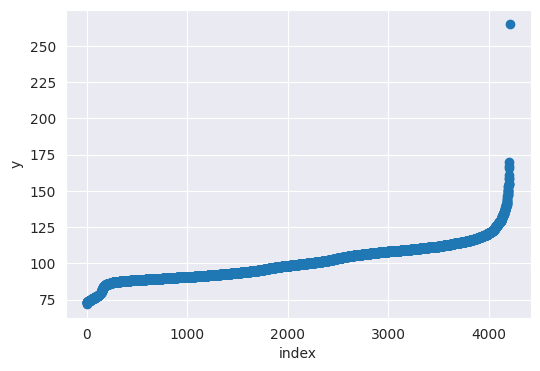

In [ ]:
plt.figure(figsize = (6, 4))
plt.scatter(range(train.shape[0]), np.sort(train.y.values))
plt.xlabel('index')
plt.ylabel('y')
plt.show()

<ipython-input-12-4bcf68c022b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y'].iloc[train['y']>limit] = limit


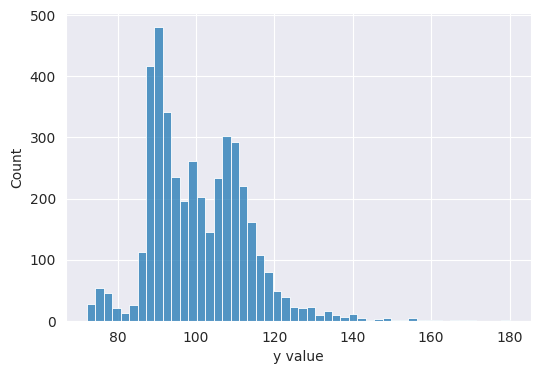

In [ ]:
limit = 180
train['y'].iloc[train['y']>limit] = limit

plt.figure(figsize = (6, 4))
sns.histplot(train.y.values, bins=50)
plt.xlabel('y value')
plt.show()

In [ ]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [ ]:
dtype_df.loc[dtype_df['Column Type'] == object]

,Count,Column Type
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


In [ ]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['colmun_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df

,colmun_name,missing_count


In [ ]:
unique_values_dict = {}
for col in train.columns:
  if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    unique_value = str(np.sort(train[col].unique()).tolist())
    col_list = unique_values_dict.get(unique_value, [])
    col_list.append(col)
    unique_values_dict[unique_value] = col_list

for unique_val, columns in unique_values_dict.items():
  print("Columns containing the unique values : ", unique_val)
  print(columns)
  print("----------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

In [ ]:
# 모든 값이 0 인 column들은 제외해도 될 것 같다

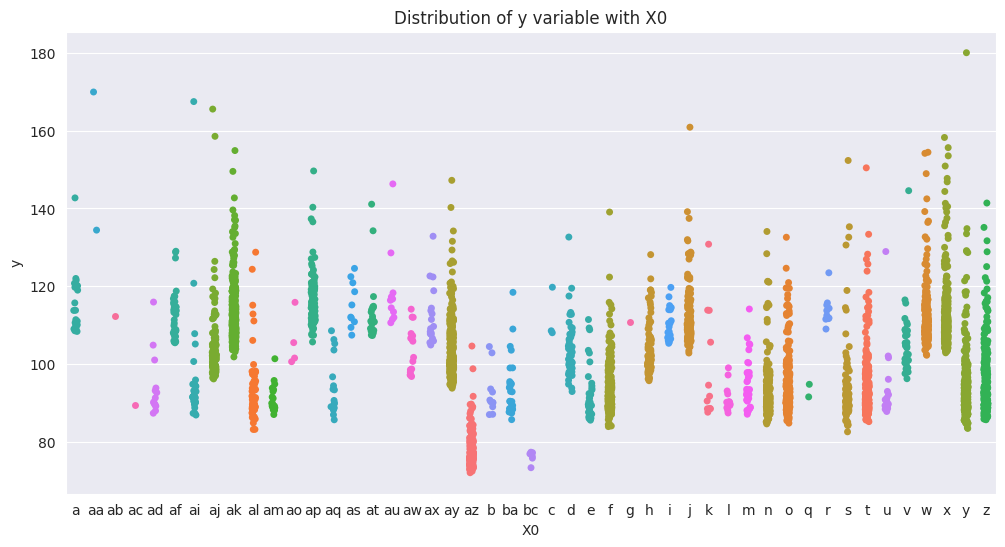

In [ ]:
var_name = "X0"
col_order = np.sort(train[var_name].unique()).tolist()
plt.figure(figsize = (12, 6))
sns.stripplot(data=train, x=var_name, y='y', order=col_order, hue=var_name, legend=False)
plt.xlabel(var_name)
plt.ylabel('y')
plt.title("Distribution of y variable with " + var_name)
plt.show()

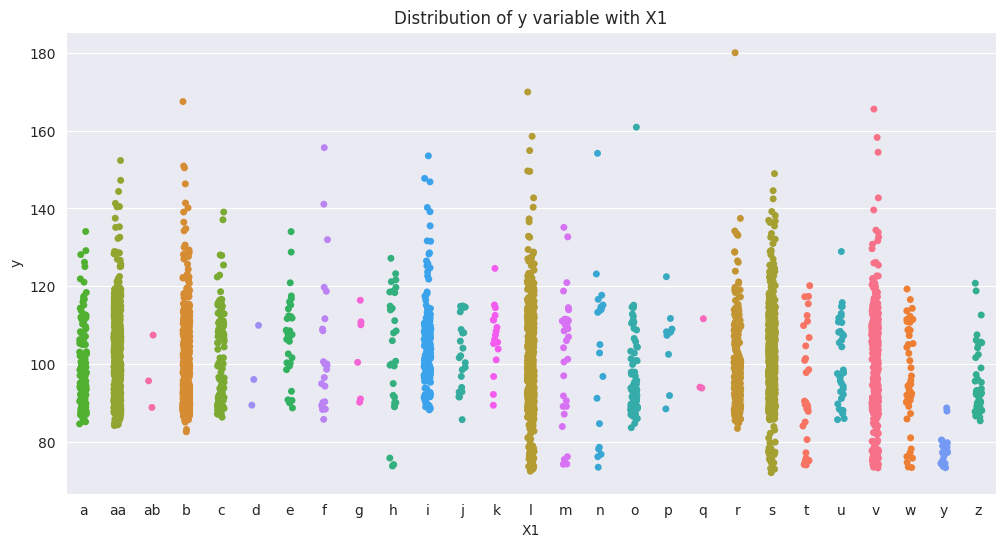

In [ ]:
var_name = "X1"
col_order = np.sort(train[var_name].unique()).tolist()
plt.figure(figsize = (12, 6))
sns.stripplot(data=train, x=var_name, y='y', order=col_order, hue=var_name, legend=False)
plt.xlabel(var_name)
plt.ylabel('y')
plt.title("Distribution of y variable with " + var_name)
plt.show()

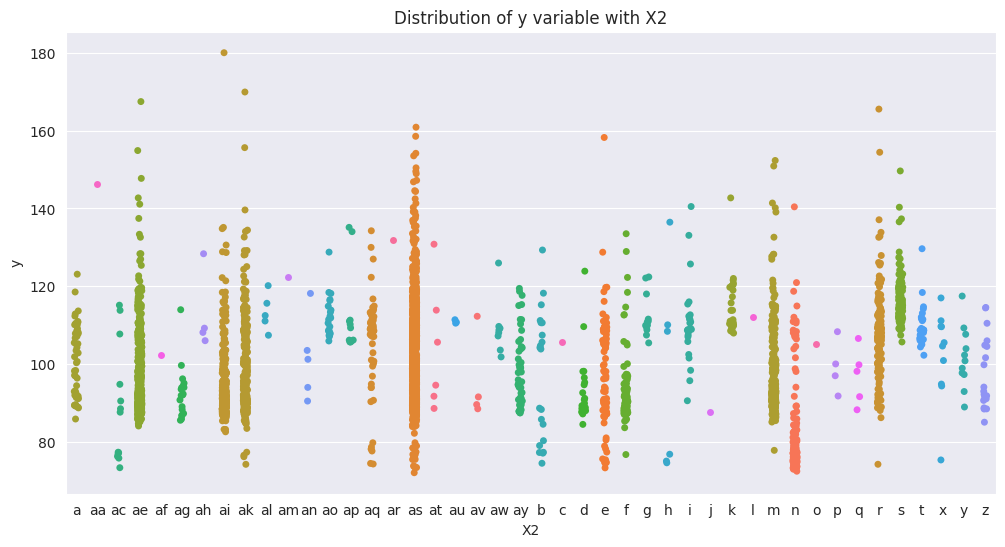

In [ ]:
var_name = "X2"
col_order = np.sort(train[var_name].unique()).tolist()
plt.figure(figsize = (12, 6))
sns.stripplot(data=train, x=var_name, y='y', order=col_order, hue=var_name, legend=False)
plt.xlabel(var_name)
plt.ylabel('y')
plt.title("Distribution of y variable with " + var_name)
plt.show()

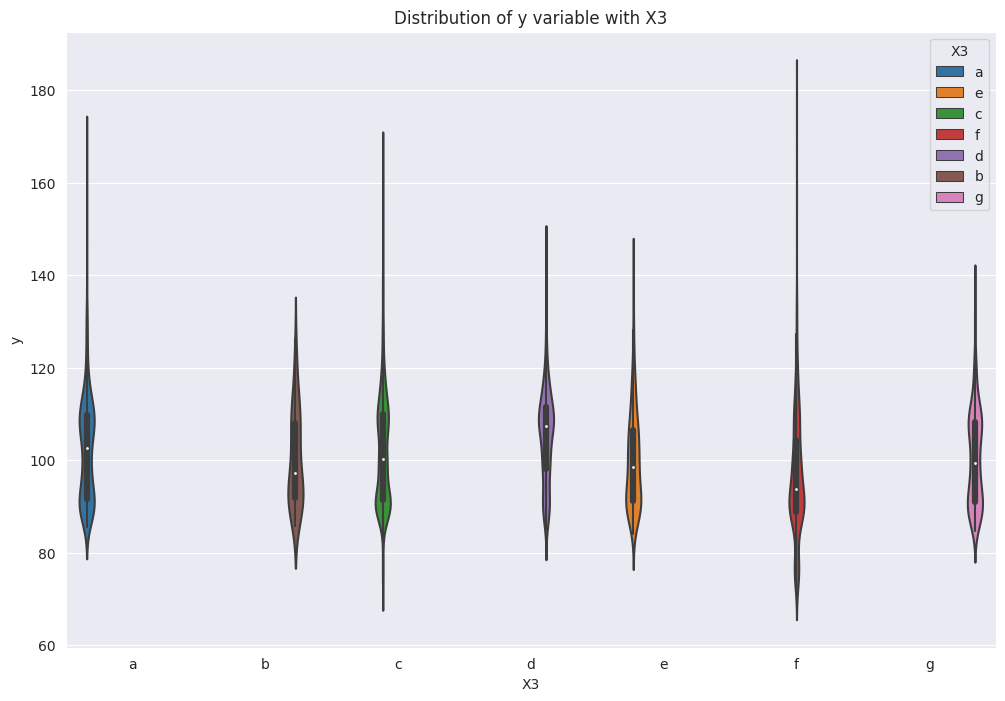

In [ ]:
var_name = "X3"
col_order = np.sort(train[var_name].unique()).tolist()
plt.figure(figsize = (12, 8))
sns.violinplot(data=train, x=var_name, y='y', order=col_order, hue=var_name, legend=False)
plt.xlabel(var_name)
plt.ylabel('y')
plt.title("Distribution of y variable with " + var_name)
plt.show()

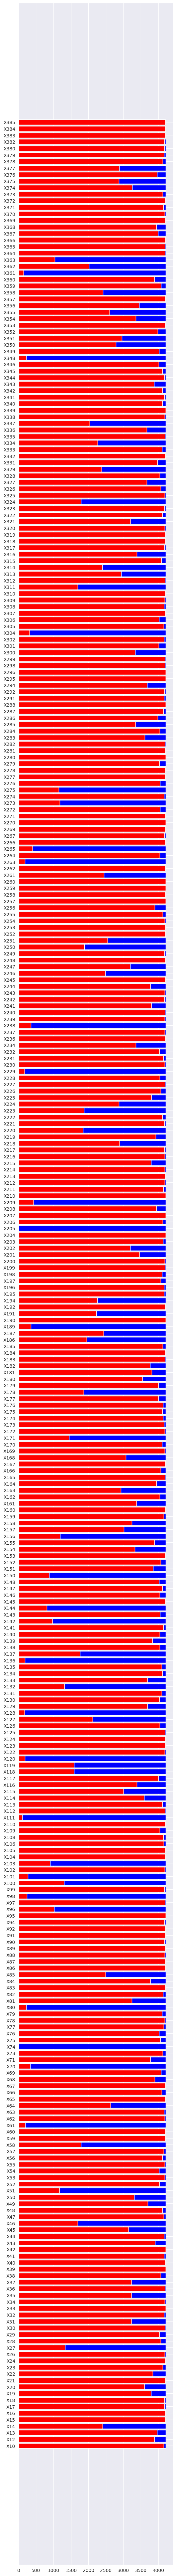

In [ ]:
zero_count_list = []
one_count_list = []

col_list = unique_values_dict['[0, 1]']
for col in col_list:
  zero_count_list.append((train[col]==0).sum())
  one_count_list.append((train[col]==1).sum())

N = len(col_list)
plt.figure(figsize=(6, 100))
plt.barh(col_list, zero_count_list, color='red')
plt.barh(col_list, one_count_list, left=zero_count_list, color='blue')
plt.show()

In [ ]:
zero_mean_list = []
one_mean_list = []
col_list = unique_values_dict['[0, 1]']
for col in col_list:
  zero_mean_list.append(train.loc[train[col]==0].y.mean())
  one_mean_list.append(train.loc[train[col]==1].y.mean())

new_df = pd.DataFrame(columns = col_list, index = [0, 1], data = [zero_mean_list, one_mean_list])
new_df = new_df.T
new_df.index.name = 'column_name'
new_df.columns.name = 'value'
new_df

value,0,1
column_name,,
X10,100.688500,97.723214
X12,100.323075,104.664905
X13,100.495972,103.136516
X14,98.509709,103.506643
X15,100.642648,114.110000
...,...,...
X380,100.602053,106.419706
X382,100.826232,77.520938
X383,100.628165,113.184286


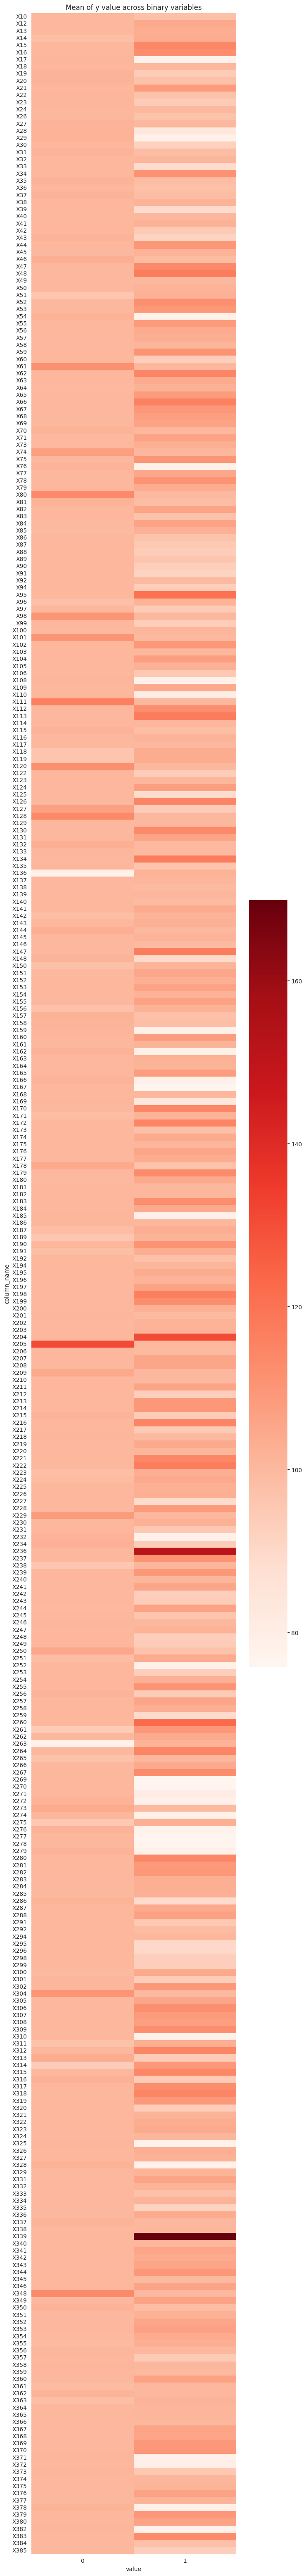

In [ ]:
plt.figure(figsize=(8,80))
sns.heatmap(new_df, cmap='Reds')
plt.title("Mean of y value across binary variables")
plt.show()

In [ ]:
# 0과 1의 count가 고르게 분포되어 있으면서, y 값(평균)의 차이가 확실한 변수들이 분석하기 좋음

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [ ]:
# 결측치가 있는 column


In [ ]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features = 

#### 다중공선성 처리

In [ ]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
threshold = 

#### Encoding Categorical Features

In [ ]:
# dtype이 object인 변수들 처리.


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [ ]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(X)

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = 
y =

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

### 5. 학습 및 평가

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = 

In [ ]:
print("Prediction")
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(x_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)